#   **Brain Tumor Classification**

**1. What is a brain tumor?**

A brain tumor is a mass, of an abnormal cells in a human brain. Which is can be cancerous 'glioma', 'meningioma','pituitary' or noncancerous 'notumor'. When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can be life-threatening.

So early detection and classification of brain tumors can help for selecting the most convenient treatment method to save patients life therefore.

**2. What is the Objective?**

Using Magnetic Resonance Imaging (MRI), we will improve health diagnosis like detecting the tumor and classifying the tumor in terms of grade and type.
We are gonna use Convolution Neural Network (CNN) to predict the type of a brain tumor base on the following Dataset: https://www.kaggle.com/masoudnickparvar/brain-tumor-mri-dataset

In [1]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# ***visualize the data***

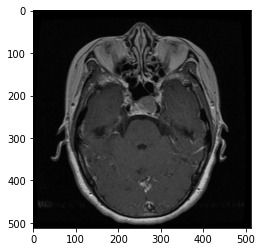

In [2]:
# Load Data 
data_dir = ('../input/brain-tumor-mri-dataset/Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img)) 
        plt.imshow(img_array);

# Process Data

In [3]:
# The image shape.
img_array.shape

(512, 512, 3)

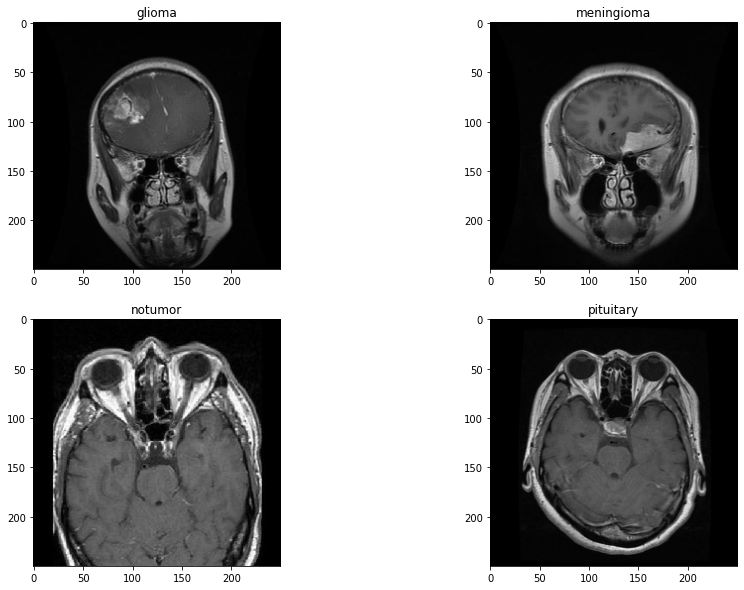

In [4]:
# Ploting a image of each brain tumor type
plt.figure(figsize=(15, 10))

images_path = ['/glioma/Tr-glTr_0000.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(categories[i])

In [5]:
# Enables experimental MLIR-Based TensorFlow Compiler Optimizations
tf.config.experimental.enable_mlir_graph_optimization()

# CNN - Modelling
**Define model architecture**

In [6]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(32,(3,3), input_shape=(64, 64, 1), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Neural network

model1.add(Dense(units= 252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])



# using the ImageDataGenerator to prepare the images (Resize, nomalize, etc)

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False) 

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

# Creating the train and test data.

train = generator_train.flow_from_directory('../input/brain-tumor-mri-dataset/Training', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('../input/brain-tumor-mri-dataset/Testing', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

2022-09-06 13:32:32.151063: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Trainig model 
**Compile model and fit it on training data**

In [7]:
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = 'model1_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

# Fiting the model.
history1 = model1.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model1_es, model1_rlr, model1_mcp])

2022-09-06 13:32:34.061533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:190] MLIR Graph Optimization Passes. Enabled: 1, Disabled: 1, FallbackEnabled: 0, Total: 2
2022-09-06 13:32:34.091781: I tensorflow/compiler/mlir/tensorflow/translate/import_model.cc:1852] Op type `PyFunc` is stateful but effects not modelled
2022-09-06 13:32:34.098601: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Epoch 1/100


2022-09-06 13:32:34.834014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


178/178 [==============================] - 35s 190ms/step - loss: 0.8034 - categorical_accuracy: 0.7308 - val_loss: 6.2292 - val_categorical_accuracy: 0.2477

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24766, saving model to model1_weights.h5
Epoch 2/100
178/178 [==============================] - 28s 156ms/step - loss: 0.4383 - categorical_accuracy: 0.8359 - val_loss: 4.0696 - val_categorical_accuracy: 0.2539

Epoch 00002: val_categorical_accuracy improved from 0.24766 to 0.25391, saving model to model1_weights.h5
Epoch 3/100
178/178 [==============================] - 28s 159ms/step - loss: 0.3230 - categorical_accuracy: 0.8761 - val_loss: 0.8874 - val_categorical_accuracy: 0.7148

Epoch 00003: val_categorical_accuracy improved from 0.25391 to 0.71484, saving model to model1_weights.h5
Epoch 4/100
178/178 [==============================] - 28s 159ms/step - loss: 0.2354 - categorical_accuracy: 0.9095 - val_loss: 0.2457 - val_categorical_accuracy: 0.9023

Epoch 00004: 

In [8]:
model1.evaluate(test)

41/41 [==============================] - 4s 94ms/step - loss: 0.0529 - categorical_accuracy: 0.9832


[0.05289168283343315, 0.9832189083099365]

In [9]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

# Evaluate the model

Text(0.5, 1.0, 'Accuracy on Model_1 32 Filtters - 3x3 kernel - 2 Conv Layers')

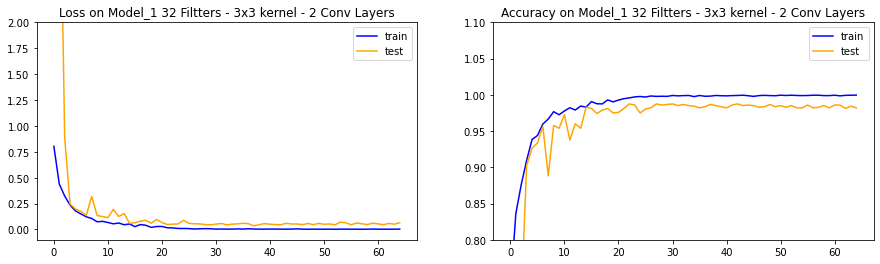

In [10]:
# Code for plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15,4))

axs[0].plot(history1.history["loss"],c = "blue")
axs[0].plot(history1.history["val_loss"],c = "orange")
axs[0].set_ylim([-0.1,2])
axs[0].legend(["train", "test"])
axs[0].set_title('Loss on Model_1 32 Filtters - 3x3 kernel - 2 Conv Layers')

axs[1].plot(history1.history["categorical_accuracy"],c = "blue")
axs[1].plot(history1.history["val_categorical_accuracy"],c = "orange")
axs[1].set_ylim([0.8,1.1])
axs[1].legend(["train", "test"])
axs[1].set_title('Accuracy on Model_1 32 Filtters - 3x3 kernel - 2 Conv Layers')